# Library

In [1]:
!pip install datasets==2.1.0
!pip install transformers==4.18.0

import os
import json
import time
from tqdm import tqdm
import glob
from IPython.display import FileLink


import pandas as pd
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt


import torchaudio
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 10.1 MB/s eta 0:00:0000:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1


# Read dataset

In [7]:
paths = []
categories = []
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold1/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [0]
        paths += [i]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold2/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [1]
        paths += [i]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold3/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [2]
        paths += [i]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold4/*"):
    if os.path.getsize(i) / 1024 / 1024 < 100:
        categories += [3]
        paths += [i]

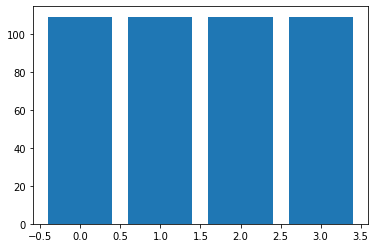

Counter({0: 109, 1: 109, 2: 109, 3: 109})

In [6]:
ct = Counter(categories)
plt.bar([x for x in ct.keys()], ct.values())
plt.show()
Counter(categories)

In [9]:
model_checkpoint = "facebook/wav2vec2-base"
max_duration = 60

In [10]:
arraies = []
labels = []
sampling_rates = []

n_c = {"history": 0, "art_music":1, "travel":2, "food":3}

for i in tqdm(range(len(categories))):
    try:
        arr, org_sr = torchaudio.load(paths[i])
        arr = torchaudio.functional.resample(arr, orig_freq=org_sr, new_freq=16000)[:, :org_sr * max_duration]
        if len(arr[0]) == 2:
            arraies += [np.array((arr[0] + arr[1])/2)]
        else:
            arraies += [np.array(arr[0])]
        sampling_rates += [org_sr]
        #labels +=  [n_c[categories[i]]]
        labels +=  [categories[i]]
    except:
        print(i)

100%|██████████| 544/544 [27:43<00:00,  3.06s/it]


# Make dataset

In [14]:
df_train_arraies = []
df_valid_arraies = []
df_train_labels = []
df_valid_labels = []
limit = 14
for i in range(len(labels)):
    if df_valid_labels.count(labels[i]) < limit:
        df_valid_labels += [labels[i]]
        df_valid_arraies +=[arraies[i]]
    else:
        df_train_labels += [labels[i]]
        df_train_arraies += [arraies[i]] 

In [15]:
from datasets import Dataset, DatasetDict

tdf =pd.DataFrame({"array": df_train_arraies, "sampling_rate": [0 for i in df_train_arraies ] , "label": df_train_labels })
vdf =pd.DataFrame({"array": df_valid_arraies, "sampling_rate": [0 for i in df_valid_arraies ], "label": df_valid_labels })
tdf = tdf.sample(frac=1).reset_index(drop=True)

tds = Dataset.from_pandas(tdf)
vds = Dataset.from_pandas(vdf)

ds = DatasetDict()
ds["train"] =  tds
ds["validation"] =  vds

In [17]:
'''ds.save_to_disk("dataset_1800")              #  Saave reserve copy of dataset
!tar -cvf archive_1800.tar.gz /kaggle/working/dataset_1800
FileLink(r'archive_1800.tar.gz')

ds = load_from_disk("/kaggle/working/dataset_1800_30")
!cp -r /kaggle/input/archive-1800-30/kaggle/working/dataset_1800_30 ./'''

# Feature extractor

In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
feature_extractor

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [6]:
def preprocess_function(examples):
    audio_arrays = examples["array"]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True,
        padding=True
    )
    return inputs

In [7]:
encoded_dataset = ds.map(preprocess_function, remove_columns=["sampling_rate", "array"], batched=True, batch_size=2)
encoded_dataset

  0%|          | 0/196 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 392
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 44
    })
})

# Load model

In [8]:
num_labels = 4
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", 
    num_labels=num_labels
)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.bias', 'project_q.weight', 'project_q.bias', 'project_hid.bias', 'quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.bias', 'projector.weight', 'classifier.

In [9]:
model_name = "facebook/wav2vec2-base".split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_total_limit = 3,
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=45,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [11]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    print(predictions)
    print(eval_pred.label_ids)
    print(metric.compute(predictions=predictions, references=eval_pred.label_ids))
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Train

In [12]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [13]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 392
  Num Epochs = 45
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 540
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,1.391500,1.385867,0.227273
1,1.371700,1.371648,0.295455
2,1.333100,1.347392,0.431818
3,1.308400,1.312891,0.431818
4,1.274800,1.265239,0.454545
5,1.212600,1.239604,0.477273
6,1.238500,1.204087,0.454545
7,1.133600,1.183821,0.454545
8,1.157400,1.165847,0.454545
9,1.023800,1.182422,0.454545


***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.22727272727272727}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-12
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-12/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-12/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-12/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[2 2 2 2 2 2 2 2 2 0 2 1 1 2 2 2 1 2 1 1 2 1 2 1 2 1 1 2 1 2 1 2 1 3 2 2 2
 2 2 2 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.29545454545454547}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-24
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-24/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-24/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-24/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 2 0 2 2 0 0 0 0 1 1 2 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 2 1 2 1 3 2 1 0
 2 2 2 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.4318181818181818}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-36
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-36/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-36/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-36/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 2 0 0 2 0 0 0 0 1 1 0 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1 3 1 1 1 3 2 1 0
 2 2 2 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.4318181818181818}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-48
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-48/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-48/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-48/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-12] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 3 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 2 1 1 1 1 0 1 3 1 1 1 3 3 1 0
 0 0 0 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.45454545454545453}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-60
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-60/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-60/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-60/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-24] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 3 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 3 1 3 0 1 3 1 3 3 3 3 1 0
 0 0 0 1 1 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.4772727272727273}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-72
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-72/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-72/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-72/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-36] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 3 0 1 0 1 3 0 3 3 1 3 1 0
 0 0 0 3 1 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.45454545454545453}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-84
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-84/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-84/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-84/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-48] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 3 0 0 0 0 0 0 0 1 1 0 0 1 1 1 2 1 3 1 0 1 2 0 0 3 1 3 1 3 3 1 3 1 0
 0 0 0 3 1 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.45454545454545453}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-96
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-96/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-96/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-96/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-60] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 3 1 0 1 3 1 1 0 1 3 1 3 3 1 3 1 0
 0 0 0 3 1 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.45454545454545453}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-108
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-108/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-108/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-108/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-84] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 3 0 0 0 0 0 0 0 1 0 0 0 1 1 1 3 0 3 1 3 2 3 0 0 3 1 3 0 3 3 3 3 2 0
 3 0 0 3 0 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.45454545454545453}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-120
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-120/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-120/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-120/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-96] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 3 1 0 2 3 0 0 0 1 3 0 2 2 3 3 2 0
 0 0 0 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5227272727272727}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-132
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-132/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-132/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-132/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-72] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 3 0 0 0 0 0 0 0 1 1 0 0 1 1 1 2 1 3 1 2 2 3 0 0 3 1 3 1 3 2 3 3 3 0
 3 0 0 3 1 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-144
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-144/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-144/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-144/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-108] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 3 1 2 2 3 0 0 0 1 3 1 2 2 3 3 3 0
 3 0 0 3 1 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-156
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-156/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-156/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-156/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-120] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 2 2 3 1 2 2 3 0 1 0 1 3 1 2 2 1 3 3 0
 0 0 0 3 1 3 1]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5454545454545454}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-168
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-168/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-168/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-168/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-132] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 2 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 2 0 3 1 2 2 3 2 0 0 0 3 1 2 3 3 3 3 0
 0 0 0 3 0 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-180
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-180/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-180/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-180/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-144] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 2 1 2 2 3 1 2 2 3 2 2 0 1 3 1 2 3 3 3 3 0
 3 0 0 3 2 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-192
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-192/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-192/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-192/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-168] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 3 0 0 0 0 1 1 0 0 0 1 1 2 2 3 1 2 2 3 3 0 2 1 3 1 2 3 3 3 3 0
 3 0 2 3 2 3 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-204
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-204/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-204/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-204/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-180] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 2 2 3 1 0 2 3 0 1 2 1 3 1 2 2 1 3 1 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-216
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-216/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-216/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-216/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-192] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 1 1 2 2 3 1 0 2 3 2 0 2 1 3 1 2 2 3 3 3 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-228
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-228/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-228/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-228/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-156] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 3 0 0 0 0 1 1 0 3 2 1 1 2 2 3 1 0 2 3 0 0 2 1 3 1 2 2 2 3 3 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5454545454545454}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-240
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-240/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-240/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-240/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-204] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 1 2 3 1 2 2 2 2 1 2 1 3 1 2 2 2 2 2 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-252
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-252/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-252/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-252/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-216] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 3 1 0 2 3 0 0 2 1 3 1 2 2 2 2 2 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-264
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-264/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-264/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-264/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-240] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 3 0 0 0 0 1 1 0 3 0 1 1 1 1 3 1 0 2 3 2 0 2 1 0 1 2 2 2 3 2 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-276
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-276/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-276/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-276/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-252] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 3 0 0 0 0 1 1 3 3 2 1 1 2 2 3 1 0 2 3 2 0 2 1 0 1 2 2 3 3 3 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-288
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-288/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-288/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-288/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-264] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 3 2 0 2 2 0 1 2 2 3 2 2 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-300
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-300/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-300/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-276] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 2 0 0 3 1 0 2 3 2 0 2 1 0 1 2 2 3 3 2 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5454545454545454}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-312
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-312/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-312/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-312/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-288] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 3 0 0 0 0 1 1 3 3 2 1 1 2 2 3 1 0 2 3 2 2 2 1 0 1 2 2 3 3 3 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-324
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-324/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-324/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-324/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 2 3 0 2 1 1 2 2 3 1 0 2 3 2 0 2 1 0 1 2 2 3 2 2 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5227272727272727}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-336
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-336/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-336/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-336/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-312] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 2 2 0 2 1 0 1 2 2 3 2 2 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-348
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-348/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-348/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-348/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-324] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 1 2 3 1 0 2 3 2 1 2 1 0 1 2 2 3 3 2 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-360
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-360/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-360/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-360/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-336] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 2 1 3 3 2 2 1 2 2 3 2 0 2 3 2 2 2 1 0 1 2 2 3 3 3 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5454545454545454}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-372
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-372/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-372/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-372/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-348] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 3 1 0 2 3 2 1 2 1 0 1 2 2 3 3 2 0
 3 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-384
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-384/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-384/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-384/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-360] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 3 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5681818181818182}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-396
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-396/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-396/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-396/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-372] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-408
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-408/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-408/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-408/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-384] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 3 0 2 3 2 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-420
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-420/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-420/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-420/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-396] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 2 3 2 1 1 1 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 2 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-432
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-432/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-432/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-432/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-408] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 1 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6363636363636364}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-444
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-444/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-444/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-444/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-228] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 3 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-456
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-456/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-456/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-456/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-420] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-468
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-468/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-468/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-468/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-432] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 2 3 2 1 1 1 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6363636363636364}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-480
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-480/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-480/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-480/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-456] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 1 2 2 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-492
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-492/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-492/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-492/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-468] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 2 3 2 1 1 1 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6363636363636364}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-504
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-504/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-504/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-504/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-480] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 2 3 2 1 1 2 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-516
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-516/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-516/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-516/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-492] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 2 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.5909090909090909}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-528
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-528/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-528/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-528/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-504] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 44
  Batch size = 8


[0 0 0 0 0 0 2 0 0 0 0 1 1 3 3 2 1 1 2 2 1 1 0 2 2 2 2 2 1 0 1 2 2 3 3 2 0
 2 0 2 3 1 3 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3]
{'accuracy': 0.6136363636363636}


Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-540
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-540/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-540/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-540/preprocessor_config.json
Deleting older checkpoint [wav2vec2-base-finetuned-ks/checkpoint-516] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from wav2vec2-base-finetuned-ks/checkpoint-444 (score: 0.6363636363636364).


TrainOutput(global_step=540, training_loss=0.6825715566398921, metrics={'train_runtime': 10773.6493, 'train_samples_per_second': 1.637, 'train_steps_per_second': 0.05, 'total_flos': 4.80225962225664e+18, 'train_loss': 0.6825715566398921, 'epoch': 44.98})